In [2]:
# Reload dependencies upon changes
%load_ext autoreload
%autoreload 2

## Dependencies

In [3]:
from functools import partial
from copy import deepcopy
import types
import typing
import sys

import numpy as np
import gym
import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl

from mazelab_experimenter import EnvRegister
from mazelab_experimenter import AgentShelve
from mazelab_experimenter import benchmark, GenericOuterHook

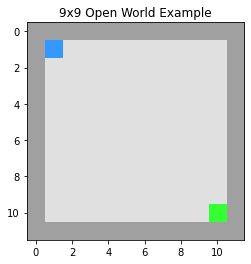

In [18]:
t = 100_000
name_openworld = EnvRegister.register(
    maze_type='gridworld', 
    name=f'gridworld-v0', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(height=12, width=12),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[10, 10]]
    ),
    time_limit=t,
    override=True
)
openworld = gym.make(name_openworld)

# Illustrate the randomly generated maze. 
_ = openworld.reset()

img_a = openworld.unwrapped.get_image()
openworld.close()

plt.imshow(img_a)
plt.title("9x9 Open World Example")

plt.show()

In [4]:
AgentShelve.get_types()

['TabularQLearner',
 'TabularQLearnerN',
 'TabularQLambda',
 'TabularQET',
 'TabularDynaQ',
 'MonteCarloQLearner',
 'RandomAgent',
 'HierQ',
 'HierQV2',
 'HierQN',
 'HierQTD',
 'HierQTS',
 'HierQLambda']

## Trace Update Comparison Watkin's Q($\lambda$), $n$-step Q-learning, and their Hierarchical Counterparts

#### Helper functions

In [5]:
def generate_trace(_env: gym.Env, budget: int = None) -> typing.List[int]:
    """ Generate an action trace within some environment using a random policy. """
    _env.reset()
    if budget is None:
        budget = _env._max_episode_steps
    
    # Keep sampling random actions until the environment goal is reached.
    done, trace = False, list()
    while (not done) and len(trace) < budget:
        # Sample random action.
        a = np.random.randint(_env.action_space.n)
        
        # Take a step in the environment and remember the action.
        s, r, done, _ = _env.step(a)
        trace.append(a)
    
    # Clear environment variable and return action trace.
    _env.close()
    return trace


def generate_agent(_env: gym.Env, name: str, **kwargs) -> typing.Callable:
    """ Helper function for instantiating agents with a fixed goal given some environment. 
    """
    agent = AgentShelve.retrieve(
        agent=name, keyword_arguments=dict(
            observation_shape=_env.observation_space.shape,
            n_actions=_env.action_space.n,
            **kwargs
        ))
    agent.set_goal(agent._get_index(_env.unwrapped.maze.get_end_pos()[0]))   
    return agent
    

#### Agent Configurations for Comparison

In [87]:
# Parameter configuration for all agent-comparisons
shared_kwargs = dict(
    n_levels=4, horizons=[3, 3, 3, 3],
    lr=1, discount=0.95, epsilon=1.0, lr_decay=0.0,
    universal_top=False, relative_goals=False, relative_actions=True
)

# Individual agent configurations 
HierQ_kwargs = dict(name='HierQN', n_steps=[9, 3, 1, 100])
HierQLambda_kwargs = dict(name='HierQLambda', decay=0.9)

agent_kwargs = [HierQ_kwargs, HierQLambda_kwargs]

#### Test Trace-fixing functionality

In [71]:
def apply_trace(agent, _env: gym.Env, trace: typing.List[int]) -> None:
    """ Helper function to apply a fixed trace for the agent to perform an update on. """
    agent._fix_policy(trace)
    agent.train(_env, 1, False)


In [8]:
desired_length = 25  # Upper bound for the length of the random policy trace. 
    
action_trace = generate_trace(openworld, budget=desired_length+1)
while len(action_trace) > desired_length:
    action_trace = generate_trace(openworld, budget=desired_length+1)

print(f"Random rollout reached goal in {len(action_trace)} actions")


Random rollout reached goal in 25 actions


In [16]:
# Generate a sample agent.
agent = generate_agent(
    _env=openworld,
    **HierQLambda_kwargs,
    **shared_kwargs
)

# Assert functionality of fixing the agent's environment trace.
agent._fix_policy(action_trace)
for i in range(len(action_trace)):
    a, _ = agent.get_level_action(0, 0, 0, 0)
    assert a == action_trace[i], "Agent did not follow given path."

# Test functionality inside train function
apply_trace(agent, openworld, action_trace)

train_path = [t.action for t in agent.trace.raw]
assert all([a_path == a_train for a_path, a_train in zip(action_trace, train_path)])
    
print("Agent adheres to the trace.")

Agent adheres to the trace.


In [41]:
# Trace Collection
lim = 100
traces = list()
for i in range(lim):
    print(f"Progress: {i:5d}/{lim}", end='\r')
    tr = generate_trace(openworld, budget=100)
    while len(tr) >= 100:
        tr = generate_trace(openworld, budget=100)
    traces.append(tr)


### Visualize Trace Updates

In [28]:
def tables_to_images(agent) -> typing.List[np.ndarray]:
    """ Convert all agent's Q-tables to images by maximizing state-action values over each state.
   
    Tables are all conditioned on the environment/ extrinsic goal.
    
    """
    images = list()
    for i, c in enumerate(agent.critics):
        g = agent._level_goals[-1] if c.goal_conditioned else 0
        im = np.amax(c.table[:,g,:], axis=-1)
        
        images.append(im.reshape(agent.observation_shape))
    return images


## Hierarchical

In [92]:
# Initialize agents and perform 1-training episode with equivalent traces.
agents = [generate_agent(_env=openworld, **shared_kwargs, **p) for p in agent_kwargs]
agent_images = list()
for a in agents:
    apply_trace(a, openworld, action_trace)
    agent_images.append(tables_to_images(a))
    

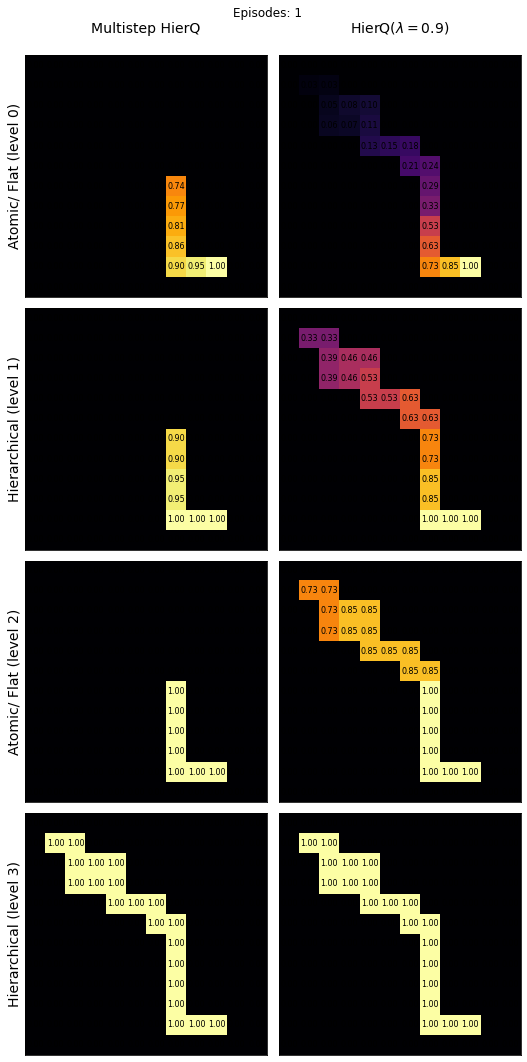

In [97]:
# Visualize backup patterns for each individual agent for one training episode conditioned on the environment goal.
s = 0.75
annotate = True
m = 4

f, ax = plt.subplots(m, len(agents), figsize=(5*len(agents)*s, m*5*s))
for i, a_im in enumerate(agent_images):
    for j, im in enumerate(a_im):
        ax[j, i].imshow(im, cmap=plt.cm.inferno)
        ax[j, i].tick_params(axis='both', which='both', bottom=False, left=False, right=False, top=False, labelleft=False, labelbottom=False)
        
        if annotate:
            rows, columns = np.meshgrid(np.arange(len(im)), np.arange(len(im)))
            for v, row, col in zip(im.ravel(), rows.flatten(), columns.flatten()):
                ax[j, i].text(row, col, f'{v:.2f}', va='center', ha='center', fontsize=8)
        
        
plt.suptitle(f"Episodes: 1")

ax[0, 0].set_ylabel("Atomic/ Flat (level 0)", fontsize=14)
ax[1, 0].set_ylabel("Hierarchical (level 1)", fontsize=14)
ax[2, 0].set_ylabel("Atomic/ Flat (level 2)", fontsize=14)
ax[3, 0].set_ylabel("Hierarchical (level 3)", fontsize=14)

# ax[0, 0].set_title("Q-Learning/\nHierQ(0)", fontsize=14)
ax[0, 0].set_title("Multistep HierQ\n", fontsize=14)
# ax[0, 2].set_title("Watkin's Q($\lambda = 0.9$)/\n HierQ($\lambda=0.9$)", fontsize=14)
ax[0, 1].set_title("HierQ($\lambda=0.9$)\n", fontsize=14)
        
plt.tight_layout()
plt.savefig(f'Backup_{1}.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Multiple training iterations

In [93]:
# Continue training for agents initialized with the same trace.
iterations = [1, 8, 90, 400]  # Cumulative: 2, 20, 200, 2000
cumulative = np.cumsum(iterations) + 1
print('Episode-schedule:', cumulative)

total = 0
train_images = list()
for its in iterations:
    print(its)
    
    iteration_images = list()
    for a in agents:
        for i in range(its):
            apply_trace(a, openworld, traces[total + i])
        
        iteration_images.append(tables_to_images(a))
    
    total += its
    train_images.append(iteration_images)

Episode-schedule: [  2  10 100 500]
1
8
90
400


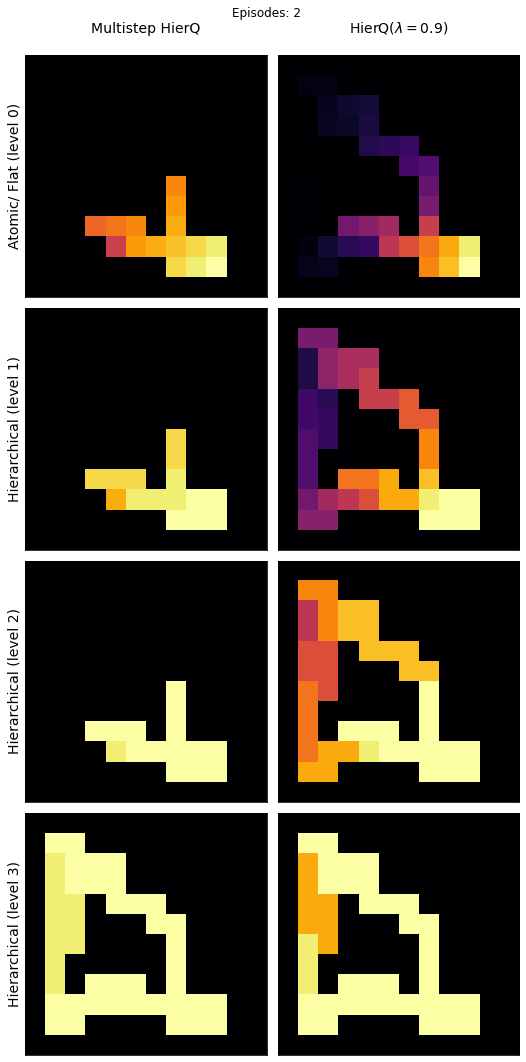

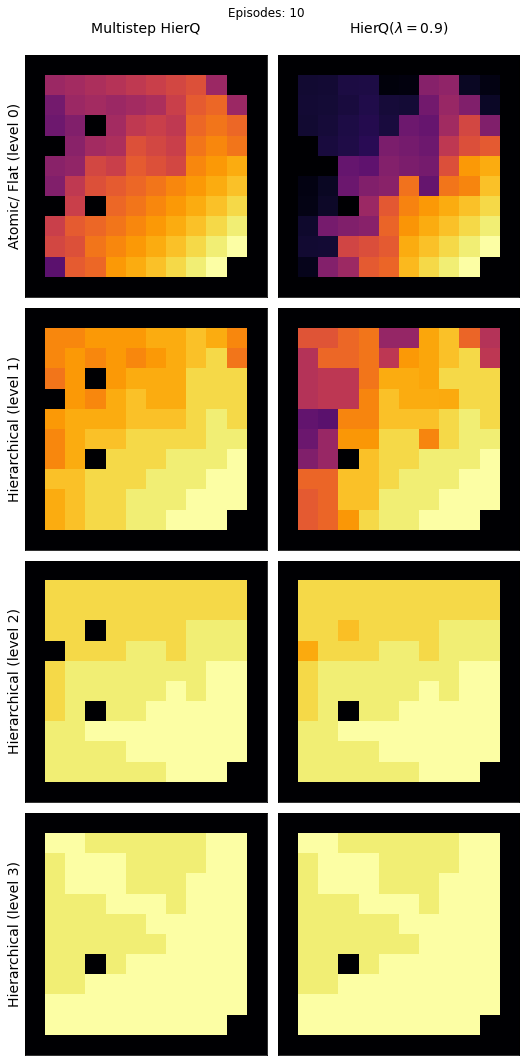

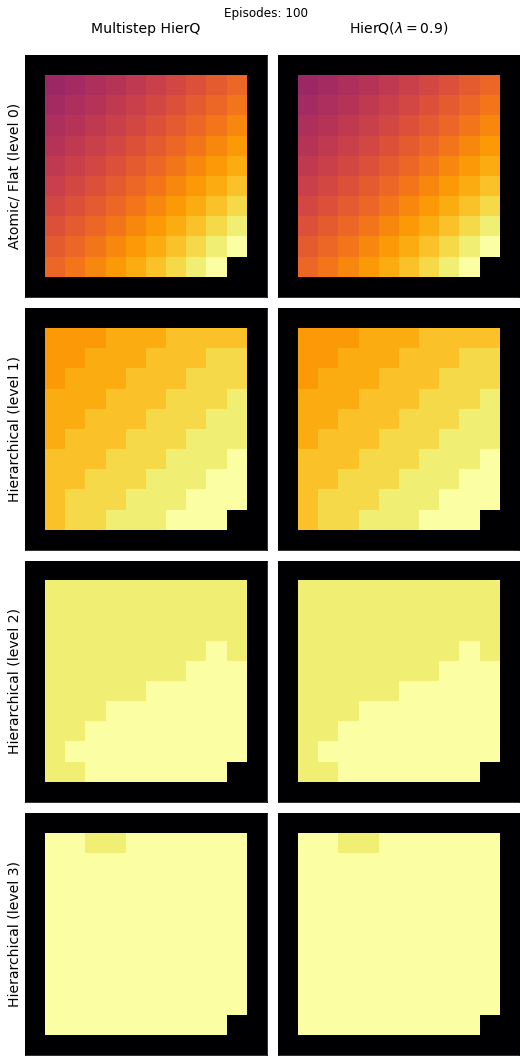

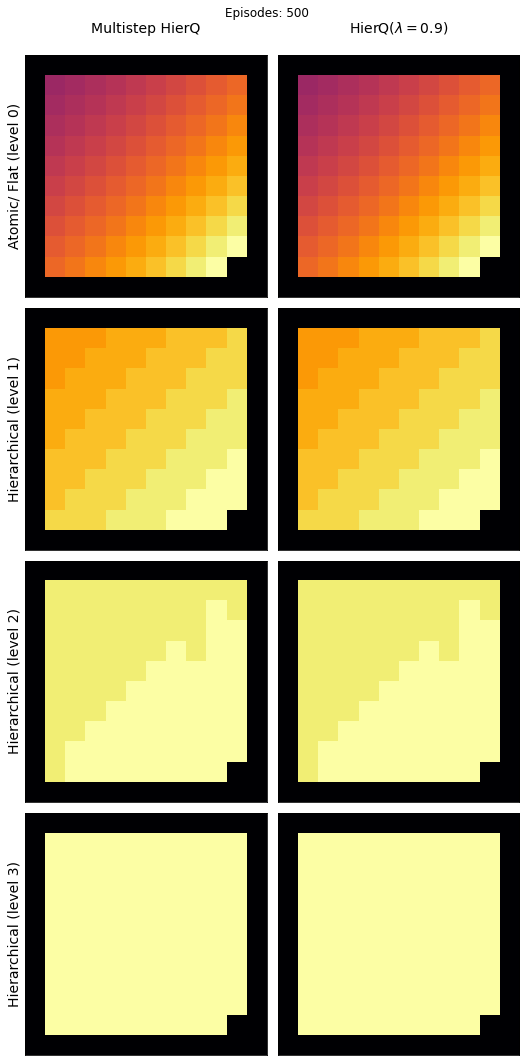

In [98]:
# Visualize backup patterns for each individual agent for one training episode conditioned on the environment goal.
s = 0.75
annotate = False
    
for num_episodes, iteration_images in zip(cumulative, train_images):

    f, ax = plt.subplots(m, len(agents), figsize=(5*len(agents)*s, m*5*s))
    for i, a_im in enumerate(iteration_images):
        for j, im in enumerate(a_im):
            ax[j, i].imshow(im, cmap=plt.cm.inferno, vmin=0, vmax=1)
            ax[j, i].tick_params(axis='both', which='both', bottom=False, left=False, right=False, top=False, labelleft=False, labelbottom=False)

            if annotate:
                rows, columns = np.meshgrid(np.arange(len(im)), np.arange(len(im)))
                for v, row, col in zip(im.ravel(), rows.flatten(), columns.flatten()):
                    ax[j, i].text(row, col, f'{v:.2f}', va='center', ha='center', fontsize=8)

    ax[0, 0].set_ylabel("Atomic/ Flat (level 0)", fontsize=14)
    ax[1, 0].set_ylabel("Hierarchical (level 1)", fontsize=14)
    ax[2, 0].set_ylabel("Hierarchical (level 2)", fontsize=14)
    ax[3, 0].set_ylabel("Hierarchical (level 3)", fontsize=14)

    # ax[0, 0].set_title("Q-Learning/\nHierQ(0)", fontsize=14)
    ax[0, 0].set_title("Multistep HierQ\n", fontsize=14)
    # ax[0, 2].set_title("Watkin's Q($\lambda = 0.9$)/\n HierQ($\lambda=0.9$)", fontsize=14)
    ax[0, 1].set_title("HierQ($\lambda=0.9$)\n", fontsize=14)

    plt.suptitle(f"Episodes: {num_episodes}")
    
    plt.tight_layout()
    plt.savefig(f'Backup_{num_episodes}.pdf', format='pdf', bbox_inches='tight')
    plt.show()

# Minimal Example performances

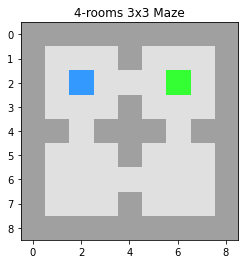

In [11]:
t = 100
name_rooms = EnvRegister.register(
    maze_type='n_rooms_square', 
    name=f'rooms-v0', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(num_rooms=4, room_size=3, gap_size=1),
    initialization_args=dict(
        start_pos=[[2, 2]], goal_pos=[[2, 6]]
    ),
    time_limit=t,
    override=True
)
rooms = gym.make(name_rooms)

# Illustrate the randomly generated maze. 
_ = rooms.reset()

img_a = rooms.unwrapped.get_image()
rooms.close()

plt.imshow(img_a)
plt.title("4-rooms 3x3 Maze")

plt.show()

#### Agent Configurations for Comparison

In [12]:
# Parameter configuration for all agent-comparisons
shared_kwargs = dict(
    lr=1, discount=0.9, epsilon=0.25, lr_decay=0.0,
    universal_top=False, relative_goals=False, relative_actions=True,
    stationary_filtering=True
)

# Individual agent configurations 
Q_kwargs = dict(name='HierQN', n_levels=1, horizons=3, n_steps=1)
MC_kwargs = dict(name='HierQN', n_levels=1, horizons=3, n_steps=t)
HierQ_kwargs = dict(name='HierQN', n_levels=2, horizons=[3,3], n_steps=1)
HierQN3_kwargs = dict(name='HierQN', n_levels=2, horizons=[3, 3], n_steps=3)
HierQNMC_kwargs = dict(name='HierQN', n_levels=2, horizons=[3, 3], n_steps=[3, t])
HierQMC_kwargs = dict(name='HierQN', n_levels=2, horizons=[3, 3], n_steps=t)
HierQMCE_kwargs = dict(name='HierQLambda', n_levels=2, horizons=3, decay=1.0)
HierQMCEFar_kwargs = dict(name='HierQLambda', n_levels=2, horizons=6, decay=1.0)
HierQ4MC_kwargs = dict(name='HierQLambda', n_levels=4, horizons=2, decay=1.0)

agent_kwargs = [Q_kwargs, MC_kwargs, HierQ_kwargs, HierQN3_kwargs, HierQNMC_kwargs, HierQMC_kwargs, HierQMCE_kwargs, HierQMCEFar_kwargs, HierQ4MC_kwargs]
names = ['Q-learning', 'MC Q-learning', 'HierQ(0)', 'HierQ n_flat=3, n_hier=3', 'HierQ n_flat=3, n_hier=MC', 'HierQ-MC', 'HierQ(1)', 'HierQ(1) far', 'HierQ(1) L=4']

#### Generate common trace

In [23]:
desired_range = (0, 10)  # Upper bound for the length of the random policy trace. 
    
action_trace = generate_trace(rooms, budget=desired_range[1]+1)
while not (desired_range[0] <= len(action_trace) < desired_range[1]):
    action_trace = generate_trace(rooms, budget=desired_range[1]+1)

print(f"Random rollout reached goal in {len(action_trace)} actions")


Random rollout reached goal in 5 actions


In [15]:
Example_HierQ_Benefit = [3, 3, 3, 1, 2, 3, 0]
Example_MC_Benefit = [3, 0, 1, 3, 3, 1, 0, 3]
Example_both = [3, 0, 1, 3, 3, 1, 2, 3, 0]
action_trace = Example_both #Example_HierQ_Benefit # [3, 0, 1, 3, 3, 1, 0, 3]

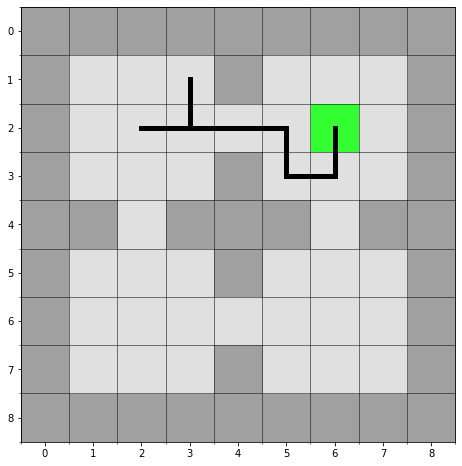

In [16]:
def plot_trajectory(env: gym.Env, trace: typing.List[int]) -> None:

    # Q-table visualization
    fig = plt.figure(figsize=(8, 8))
    img = env.unwrapped.get_image()

    # Show the maze image with overlayed quivers. The minlength=0.0 argument removes all quivers on invalid states.
    plt.imshow(img)
   
    s = env.reset()
    coords = [env.unwrapped.maze._start_idx[0]]
    for a in trace:
        *_, m = env.step(a)
        coords.append(m['coord_next'])
    
    x_offset = y_offset = base = 0
    for i in range(len(coords) - 1):
        c1, c2 = coords[i][::-1], coords[i+1][::-1]
        
        minus = base / (len(coords) - 1)   
        plt.plot([c1[0] + x_offset, c2[0] + x_offset - minus], [c1[1] - y_offset, c2[1] - y_offset - minus], linewidth=5, c='black')
        x_offset = x_offset - minus
        y_offset = y_offset - minus
            

    ax = plt.gca()
    major, minor = np.arange(0, len(img), 1), np.arange(-.5, len(img), 1)
    ax.set_xticks(major); ax.set_yticks(major)            # Major plot ticks
    ax.set_xticklabels(major); ax.set_yticklabels(major)  # Major plot tick-labels
    ax.set_xticks(minor, minor=True); ax.set_yticks(minor, minor=True)  # Minor ticks for Grid-lines.
    
    ax.grid(which='minor', color='black', linestyle='-', linewidth=.5)
    
    return fig

_ = plot_trajectory(rooms, action_trace)

## Hierarchical

In [17]:
# Initialize agents and perform 1-training episode with equivalent traces.
agents = [generate_agent(_env=rooms, **shared_kwargs, **p) for p in agent_kwargs]
agent_images = list()
for a in agents:
    apply_trace(a, rooms, action_trace)
    agent_images.append(tables_to_images(a))
    

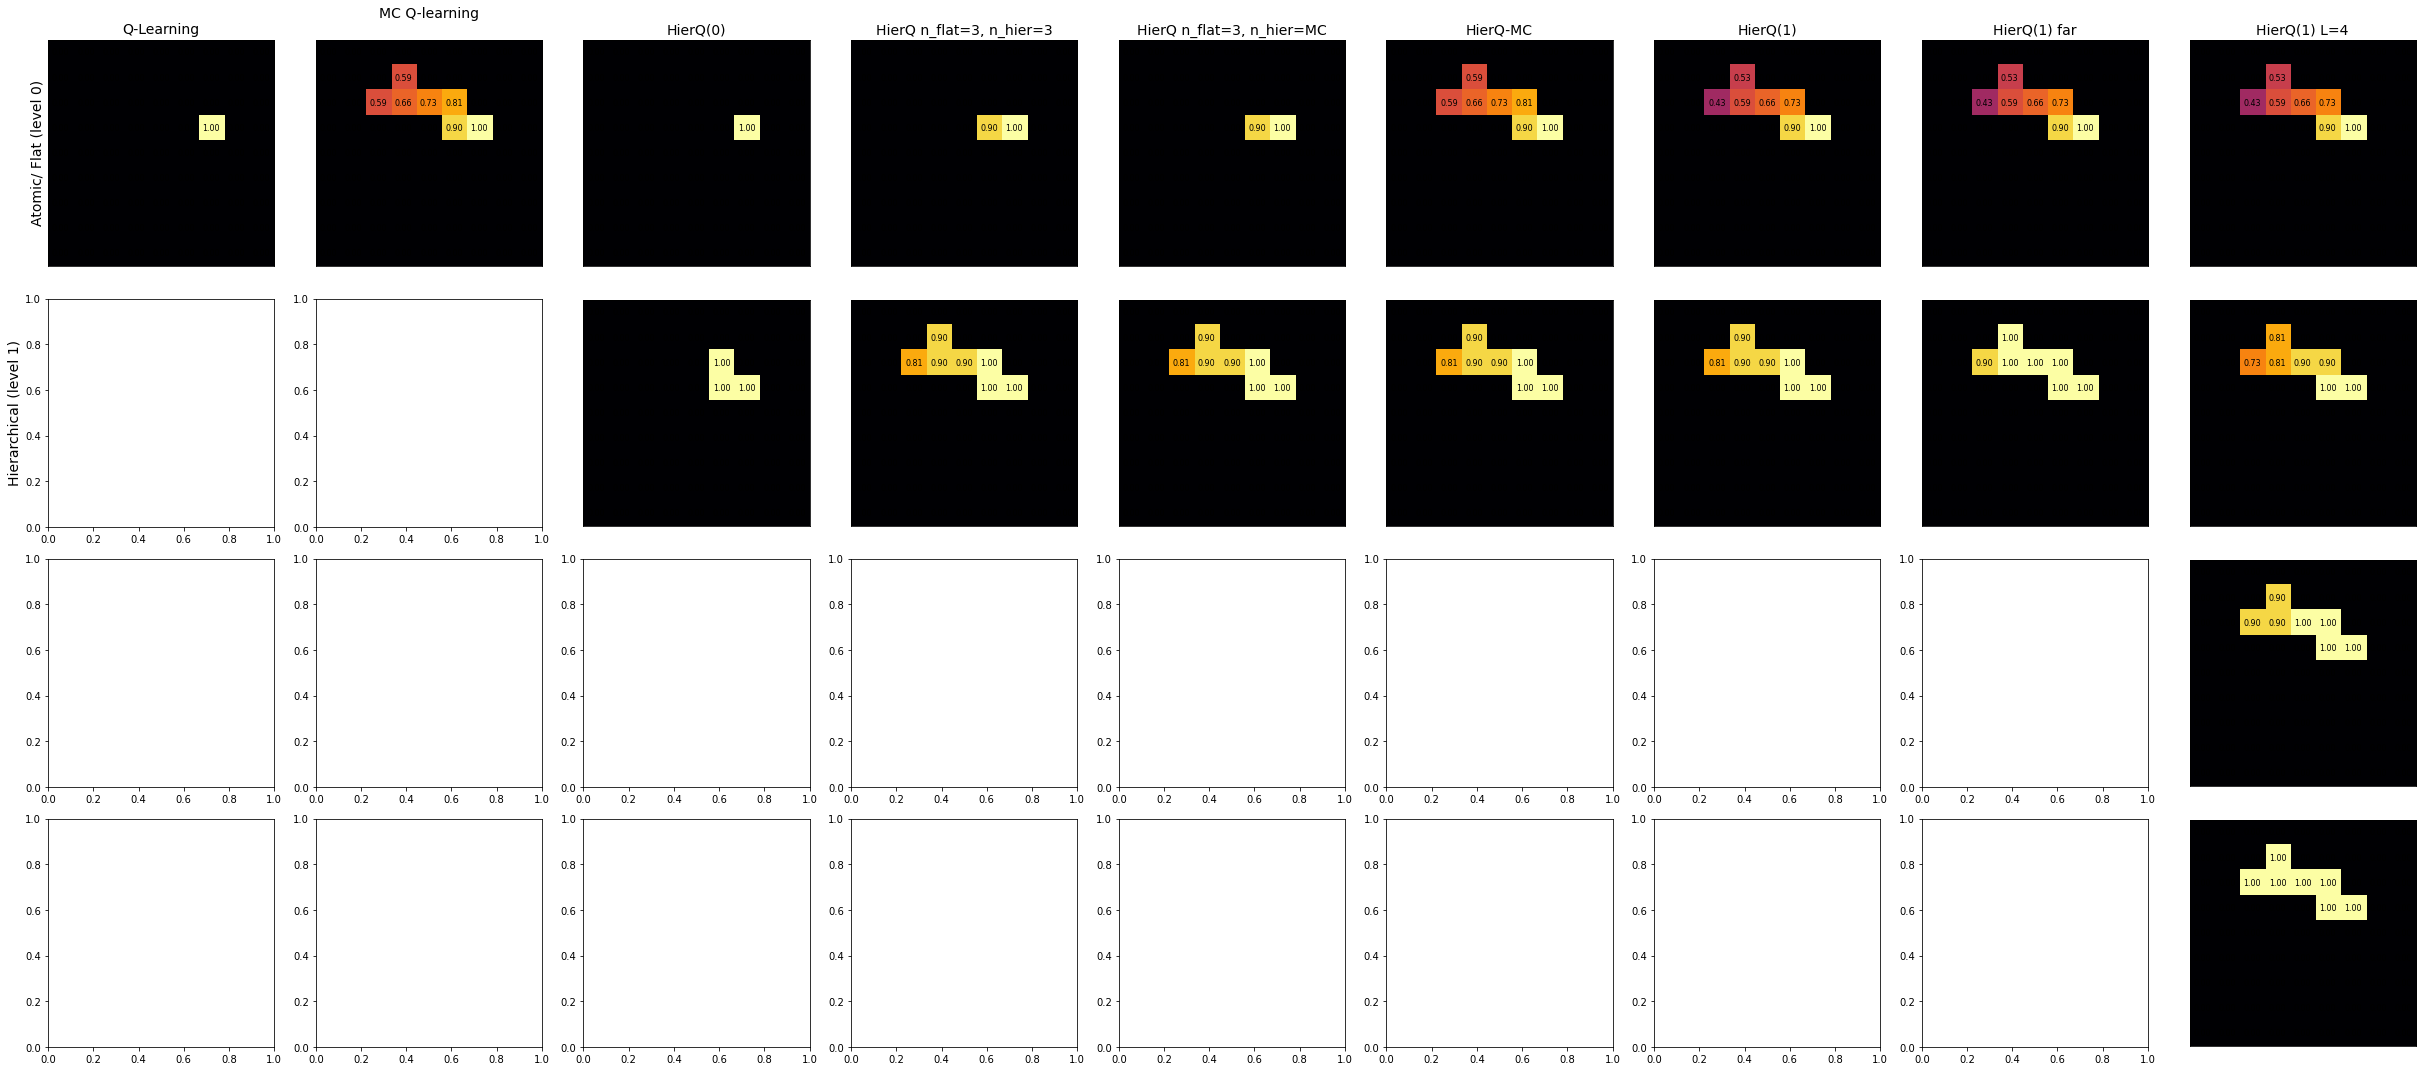

In [18]:
# Visualize backup patterns for each individual agent for one training episode conditioned on the environment goal.
s = 0.75
annotate = True
n = 4

f, ax = plt.subplots(n, len(agents), figsize=(5*len(agents)*s, 5* n *s))
for i, a_im in enumerate(agent_images):
    for j, im in enumerate(a_im):
        ax[j, i].imshow(im, cmap=plt.cm.inferno)
        ax[j, i].tick_params(axis='both', which='both', bottom=False, left=False, right=False, top=False, labelleft=False, labelbottom=False)
        
        if annotate:
            rows, columns = np.meshgrid(np.arange(len(im)), np.arange(len(im)))
            for v, row, col in zip(im.ravel(), rows.flatten(), columns.flatten()):
                ax[j, i].text(row, col, f'{v:.2f}', va='center', ha='center', fontsize=8)
        
ax[0, 0].set_ylabel("Atomic/ Flat (level 0)", fontsize=14)
ax[1, 0].set_ylabel("Hierarchical (level 1)", fontsize=14)

ax[0, 0].set_title("Q-Learning", fontsize=14)
ax[0, 1].set_title("MC Q-learning\n", fontsize=14)
ax[0, 2].set_title("HierQ(0)", fontsize=14)
ax[0, 3].set_title("HierQ n_flat=3, n_hier=3", fontsize=14)
ax[0, 4].set_title("HierQ n_flat=3, n_hier=MC", fontsize=14)
ax[0, 5].set_title("HierQ-MC", fontsize=14)
ax[0, 6].set_title("HierQ(1)", fontsize=14)
ax[0, 7].set_title("HierQ(1) far", fontsize=14)
ax[0, 8].set_title("HierQ(1) L=4", fontsize=14)
        
plt.tight_layout()
plt.show()

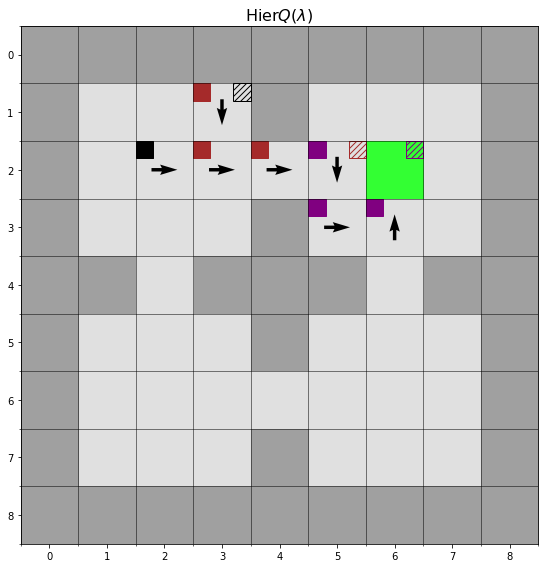

In [39]:
def plotQPolicy(env: gym.Env, agent) -> None:

    # Q-table visualization
    fig = plt.figure(figsize=(8, 8))
    img = env.unwrapped.get_image()

    # Get the trained agent's policy over the entire table for visualizing its greedy policy.
    tab = agent.critics[0].table[:, agent._get_index(env.unwrapped.maze.get_end_pos()[0]) if agent.critics[0].goal_conditioned else 0]

    if agent.n_levels >= 2:
        tab2 = agent.critics[1].table[:, agent._get_index(env.unwrapped.maze.get_end_pos()[0]) if agent.critics[1].goal_conditioned else 0, :]
        goal_mask = (tab2 == tab2.max(axis=-1)[:, None])
        count = ((np.sum(goal_mask, axis=-1)))
        
        goals = list()
        for i, g in enumerate(tab2.argmax(axis=-1)):
            if count[i] != tab2.shape[-1]:
                goals.append(agent.convert_action(1, reference=i, displaced=g, to_absolute=True))
            else:
                goals.append(-1)   
        goals = np.asarray(goals)
        
    
    mask = (tab == tab.max(axis=-1)[:, None])
    mask = (np.sum(mask, axis=-1) > 1) & (np.sum(mask, axis=-1) < 4)

    actions = np.argmax(tab, axis=-1)

    val = np.max(agent.critics[0].table[:, agent._get_index(env.unwrapped.maze.get_end_pos()[0]) if agent.critics[0].goal_conditioned else 0], axis=-1)
    # Get undefined coordinates for removing clutter in the image.
    mask = env.unwrapped.maze.objects.obstacle.positions.tolist() + env.unwrapped.maze.objects.goal.positions.tolist()
    mask = set(map(tuple, mask))

    positions, motions = list(), list()
    for i, (a, v) in enumerate(zip(actions.ravel(), val.ravel())):
        pos = np.unravel_index(i, shape=agent.observation_shape)
        positions.append(pos)
                
        motions.append(env.unwrapped.motions[a] if (pos not in mask and (v != 0)) else [0, 0])

    # Define a grid and extract for each grid-point a correct Quiver/ Arrow
    # direction for visualizing the action-selection policy.
    X, Y = list(zip(*positions))
    V, U = list(zip(*motions))

    U = np.asarray(U)
    V = np.negative(V)  # Motion is inverted vertically.

    # Show the maze image with overlayed quivers. The minlength=0.0 argument removes all quivers on invalid states.
    plt.imshow(img)
    plt.quiver(Y, X, U, V, scale=20, minlength=0.0, pivot='middle', linewidth=0.1)

    ax = plt.gca()
    if agent.n_levels >= 2:
        blanka = np.full(agent.observation_shape, np.nan).ravel()
        blankg = blanka.copy()
        
        g = (goals != -1)
        states = np.flatnonzero(g)
        state_gs = goals[states]
        
        blanka[states] = state_gs
        blankg[state_gs] = state_gs
        
        blanka = blanka.reshape(agent.observation_shape)
        blankg = blankg.reshape(agent.observation_shape)

        unique_gs = np.unique(state_gs)
        gmap = dict(zip(unique_gs, range(len(unique_gs))))
        s_to_g = dict(zip(states, state_gs))
                    
        c = ['blue', 'red', 'green', 'yellow', 'orange', 'purple', 'brown', 'black'][::-1]
        h = ['/', "|", '-', "+", "x", "o", "O", ".", "*", "\\"]
        for s in states:
            j, i = agent.S_xy[s]
            ax.add_patch(mpl.patches.Rectangle((i-.5, j-.5), 0.3, 0.3, hatch=h[gmap[s_to_g[s]]], fill=True, snap=True, color=c[gmap[s_to_g[s]]]))

        for s in unique_gs:
            j, i = agent.S_xy[s]
            ax.add_patch(mpl.patches.Rectangle((i+.2, j-.5), 0.3, 0.3, hatch='////', fill=False, snap=True, color=c[gmap[s]]))
    
    major, minor = np.arange(0, len(img), 1), np.arange(-.5, len(img), 1)
    ax.set_xticks(major); ax.set_yticks(major)            # Major plot ticks
    ax.set_xticklabels(major); ax.set_yticklabels(major)  # Major plot tick-labels
    ax.set_xticks(minor, minor=True); ax.set_yticks(minor, minor=True)  # Minor ticks for Grid-lines.
    
    ax.grid(which='minor', color='black', linestyle='-', linewidth=.5)
    
    return fig


names = ['Q-learning', 'MC Q-learning', 'HierQ(0)', "HierQ n_flat=3, n_hier=3", 'HierQ n_flat=3, n_hier=MC', 'HierQ-MC', 'HierQ(1)', 'HierQ(1) Far', 'HierQ(1) L=4']
for i, agent in enumerate(agents):
    if i == 5:
        plotQPolicy(rooms, agent)
        plt.title(r'Hier$Q(\lambda)$', fontsize=16)
        plt.tight_layout()
        plt.savefig('HierQExample.pdf', format='pdf')

# 4-Level Hierarchy Random Reward

In [23]:
# Parameter configuration for all agent-comparisons
shared_kwargs = dict(
    lr=1.0, discount=0.95, epsilon=0.25, lr_decay=0.5,
    universal_top=False, relative_goals=False, relative_actions=True,
    stationary_filtering=True
)

# Individual agent configurations 
Q = dict(name='HierQLambda', n_levels=1, horizons=3, decay=0.0)
HierQ = dict(name='HierQLambda', n_levels=2, horizons=3, decay=0.0)
HierQ1 = dict(name='HierQLambda', n_levels=1, horizons=3, decay=0.9)
HierQ2 = dict(name='HierQLambda', n_levels=2, horizons=3, decay=0.9)
HierQ4 = dict(name='HierQLambda', n_levels=4, horizons=3, decay=0.9)

agent_kwargs = [Q, HierQ, HierQ1, HierQ2, HierQ4]
names = ['Q-learning', r'Hier$Q(\lambda = 0)$', r"Watkin's $Q(\lambda = 0.9)$", r'Hier$Q_2(\lambda = 0.9)$', r'Hier$Q_4(\lambda = 0.9)$']

#### Random shared trace generation

In [32]:
action_traces = [generate_trace(openworld) for _ in range(8)]

print([len(x) for x in action_traces])

[762, 35, 394, 141, 314, 170, 86, 1072]


In [ ]:
agents = [generate_agent(_env=openworld, **shared_kwargs, **p) for p in agent_kwargs]
agent_images = list()
for a in agents:
    
    for i, t in enumerate(action_traces):
        apply_trace(a, openworld, t)
        if i < 7:
            a.critics[-1].table[...] = 0.0
        
    

In [4]:
x = np.eye(8)
x

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [55]:
%precision 4

'%.4f'

In [40]:
import itertools
x = np.asarray(list(itertools.product([0, 1], repeat=3)))
x = np.hstack([np.ones((len(x), 1)), x])
print(x.shape)

(8, 4)


In [41]:
x

array([[1., 0., 0., 0.],
       [1., 0., 0., 1.],
       [1., 0., 1., 0.],
       [1., 0., 1., 1.],
       [1., 1., 0., 0.],
       [1., 1., 0., 1.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]])

In [7]:
def compute_HammingDistance(X):
    return (X[:, None, :] != X).sum(2)

In [21]:
q, r = np.linalg.qr(x)

w = q * np.sqrt(q.shape[0] / q.shape[1])

print(np.sqrt(q.shape[0] / q.shape[1]))

3.0237157840738176


In [22]:
def showouter(A):
    return np.round(A.dot(A.T), 3)
    

In [47]:
showouter(w) * np.eye(len(w))

array([[ 1.,  0.,  0., ..., -0., -0., -0.],
       [ 0.,  1.,  0., ..., -0., -0., -0.],
       [ 0.,  0.,  1., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ...,  1.,  0.,  0.],
       [-0., -0., -0., ...,  0.,  1.,  0.],
       [-0., -0., -0., ...,  0.,  0.,  1.]])

In [14]:
compute_HammingDistance(x)

array([[ 0,  1,  1, ..., 11, 11, 12],
       [ 1,  0,  2, ..., 10, 12, 11],
       [ 1,  2,  0, ..., 12, 10, 11],
       ...,
       [11, 10, 12, ...,  0,  2,  1],
       [11, 12, 10, ...,  2,  0,  1],
       [12, 11, 11, ...,  1,  1,  0]])

In [44]:
np.linalg.matrix_rank(showouter(w))
showouter(w).shape

(64, 64)

In [257]:
np.round((q[0].reshape(1, -1) * q).sum(axis = -1), 3)[0]

0.187

In [297]:
np.sqrt(1 / q.shape[0])

0.1767766952966369

In [277]:
q[0] * q[0]

array([0.031, 0.031, 0.031, 0.031, 0.031, 0.031])

In [276]:
np.sum(q[0] * q[0]) * (q.shape[0] / q.shape[1])

0.9999999999999979

In [260]:
q.shape[1] / q.shape[0]

0.1875

In [87]:
np.round(q.T.dot(q), 3)

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1., -0.,  0.],
       [ 0., -0.,  1., -0.],
       [ 0.,  0., -0.,  1.]])